## IMPORTANT

In order to query images from the database using python you must register your email with JSOC (Joint Space Operations Center): http://jsoc.stanford.edu/ajax/register_email.html

Please modify the email below to the appropriate email

In [1]:
jsoc_email = "david.boils488@topper.wku.edu"

In [2]:
%matplotlib inline

#import torch

import sunpy

import aiapy
import aiapy.data.sample as sample_data
from aiapy.calibrate import normalize_exposure, register, update_pointing

import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import scipy
from sunpy.net import Fido, attrs as a
# Set default fig size for matplotlib
plt.rcParams['figure.figsize'] = [8, 8]

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

aia_lev1_193a_2013_03_15t12_01_06_84z_image_lev1.fits:   0%|          | 0.00/12.5M [00:00<?, ?B/s]

aia_lev1_171a_2019_01_01t00_00_09_35z_image_lev1.fits:   0%|          | 0.00/11.6M [00:00<?, ?B/s]

aia_lev1_94a_2019_01_01t00_00_11_12z_image_lev1.fits:   0%|          | 0.00/10.5M [00:00<?, ?B/s]

Documentation on sunpy:

https://docs.sunpy.org/en/stable/

Documentation on aiapy:

https://aiapy.readthedocs.io/en/stable/

Documentation on astropy:

https://docs.astropy.org/en/stable/index.html

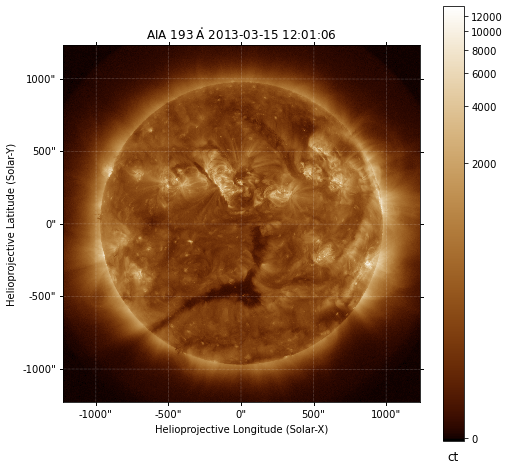

In [3]:
# Download a sample image
m = sunpy.map.Map(sample_data.AIA_193_IMAGE)

# View it
m.peek()

In [4]:
# Technically the scale and rotation of this image is off:
print(m.scale)
print(m.rotation_matrix)

SpatialPair(axis1=<Quantity 0.600714 arcsec / pix>, axis2=<Quantity 0.600714 arcsec / pix>)
[[ 0.99999949 -0.00101138]
 [ 0.00101138  0.99999949]]


In [5]:
m = register(m)

print(m.scale)
print(m.rotation_matrix)

SpatialPair(axis1=<Quantity 0.6 arcsec / pix>, axis2=<Quantity 0.6 arcsec / pix>)
[[1.00000000e+00 0.00000000e+00]
 [2.16840434e-19 1.00000000e+00]]


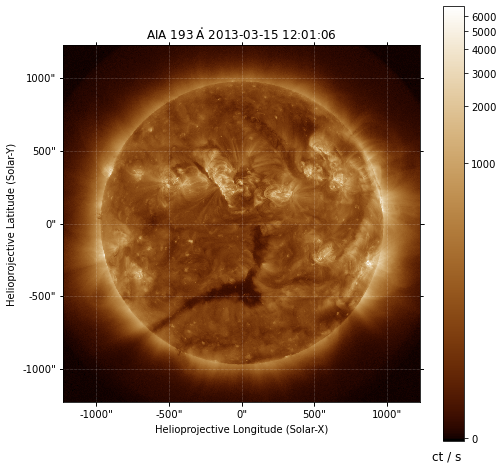

In [6]:
# We should also normalize exposure
m = normalize_exposure(m)

m.peek()

What if we want a non sample image?

We can use Fido!

Fido is a unified data search and retrieval tool.

It provides simultaneous access to a variety of online data sources, some cover multiple instruments and data products like the Virtual Solar Observatory and some are specific to a single source.

In [7]:
from sunpy.net import Fido, attrs as a

In [8]:
# ALL AIA images in that time range
Fido.search(a.Time('2022/1/25 21:00:00', '2022/1/25 23:59:59'), a.Instrument.aia, a.Level.one)

Start Time,End Time,Source,Instrument,Wavelength [2],Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size,Extra Flags,Info
,,,,Angstrom,,,,,,,Mibyte,,
Time,Time,str3,str3,float64,str4,str9,str6,str4,str4,str8,float64,str1,str106
2022-01-25 21:00:00.000,2022-01-25 21:09:03.000,SDO,AIA,1600.0 .. 1600.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,1551.5625,S,"AIA level 1, 4096x4096 [24 records] [0 eclipse] [2 darks] [0.000 to 2.901 exposure] [100.00 avg. percentd]"
2022-01-25 21:00:02.000,2022-01-25 21:09:17.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,3038.47656,S,"AIA level 1, 4096x4096 [47 records] [0 eclipse] [2 darks] [0.000 to 2.000 exposure] [100.00 avg. percentd]"
2022-01-25 21:00:03.000,2022-01-25 21:09:12.000,SDO,AIA,94.0 .. 94.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,2973.82812,S,"AIA level 1, 4096x4096 [46 records] [0 eclipse] [2 darks] [0.000 to 2.901 exposure] [100.00 avg. percentd]"
2022-01-25 21:00:05.000,2022-01-25 21:09:19.000,SDO,AIA,131.0 .. 131.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,3038.47656,S,"AIA level 1, 4096x4096 [47 records] [0 eclipse] [2 darks] [0.000 to 2.901 exposure] [100.00 avg. percentd]"
2022-01-25 21:00:06.000,2022-01-25 21:09:22.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,3038.47656,S,"AIA level 1, 4096x4096 [47 records] [0 eclipse] [2 darks] [0.000 to 2.000 exposure] [100.00 avg. percentd]"
2022-01-25 21:00:08.000,2022-01-25 21:09:10.000,SDO,AIA,211.0 .. 211.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,2973.82812,S,"AIA level 1, 4096x4096 [46 records] [0 eclipse] [2 darks] [0.000 to 2.901 exposure] [100.00 avg. percentd]"
2022-01-25 21:00:09.000,2022-01-25 21:09:18.000,SDO,AIA,304.0 .. 304.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,3038.47656,S,"AIA level 1, 4096x4096 [47 records] [0 eclipse] [2 darks] [0.000 to 2.902 exposure] [100.00 avg. percentd]"
2022-01-25 21:00:11.000,2022-01-25 21:09:13.000,SDO,AIA,335.0 .. 335.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,2973.82812,S,"AIA level 1, 4096x4096 [46 records] [0 eclipse] [1 darks] [0.000 to 2.901 exposure] [100.00 avg. percentd]"


In [9]:
# Filter only a specific wavelength
Fido.search(a.Time('2022/1/4 00:09:00', '2022/1/4 00:9:12'), a.Instrument.aia, 
            a.Wavelength(335*u.angstrom), a.Level.one)

Start Time,End Time,Source,Instrument,Wavelength [2],Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size,Info
,,,,Angstrom,,,,,,,Mibyte,
Time,Time,str3,str3,float64,str4,str9,str6,str4,str4,str8,float64,str57
2022-01-04 00:09:00.000,2022-01-04 00:09:01.000,SDO,AIA,335.0 .. 335.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.901 exposure] [100.00 percentd]"
2022-01-04 00:09:12.000,2022-01-04 00:09:13.000,SDO,AIA,335.0 .. 335.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.901 exposure] [100.00 percentd]"


In [10]:
# Search for multiple wavelengths using pipe `|` operator
Fido.search(a.Time('2022/1/4 00:09:00', '2022/1/4 00:9:12'), a.Instrument.aia, 
            a.Wavelength(1600*u.angstrom) | a.Wavelength(211*u.angstrom), a.Level.one)

Start Time,End Time,Source,Instrument,Wavelength [2],Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size,Info
,,,,Angstrom,,,,,,,Mibyte,
Time,Time,str3,str3,float64,str4,str9,str6,str4,str4,str8,float64,str57
2022-01-04 00:09:02.000,2022-01-04 00:09:03.000,SDO,AIA,1600.0 .. 1600.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.901 exposure] [100.00 percentd]"
Start Time,End Time,Source,Instrument,Wavelength [2],Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size,Info
,,,,Angstrom,,,,,,,Mibyte,
Time,Time,str3,str3,float64,str4,str9,str6,str4,str4,str8,float64,str57
2022-01-04 00:09:09.000,2022-01-04 00:09:10.000,SDO,AIA,211.0 .. 211.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.901 exposure] [100.00 percentd]"


The provider on all of those images is JSOC, which makes the download process a little more complicated.



In [11]:
# DATE-OBS is the time the image acquisition was started
# T_OBS is the halfway point of the observation
# EXPTIME is how long the observation took
# T_REC is the slotted observation time, groups all images into 1 set even though they are taken technically at different times
# All according to https://www.lmsal.com/sdodocs/doc?cmd=dcur&proj_num=SDOD0019&file_type=pdf

startdate = '2022/01/26 23:49:00'
enddate='2012/07/20 00:00:00'


results = Fido.search(a.Time(startdate, startdate),
                      a.jsoc.Notify(jsoc_email), a.jsoc.Series('aia.lev1_euv_12s'),)

results.show()

T_REC,T_OBS,WAVELNTH,DATE,FSN,EXPTIME,QUALITY,ORIGIN,TELESCOP,INSTRUME,DATE__OBS,DATE-OBS,CAMERA,IMG_TYPE,EXPSDEV,INT_TIME,WAVEUNIT,WAVE_STR,FID,QUALLEV0,TOTVALS,DATAVALS,MISSVALS,PERCENTD,DATAMIN,DATAMAX,DATAMEDN,DATAMEAN,DATARMS,DATASKEW,DATAKURT,DATACENT,DATAP01,DATAP10,DATAP25,DATAP75,DATAP90,DATAP95,DATAP98,DATAP99,NSATPIX,OSCNMEAN,OSCNRMS,FLAT_REC,NSPIKES,CTYPE1,CUNIT1,CRVAL1,CDELT1,CRPIX1,CTYPE2,CUNIT2,CRVAL2,CDELT2,CRPIX2,CROTA2,R_SUN,MPO_REC,INST_ROT,IMSCL_MP,X0_MP,Y0_MP,ASD_REC,SAT_Y0,SAT_Z0,SAT_ROT,ACS_MODE,ACS_ECLP,ACS_SUNP,ACS_SAFE,ACS_CGT,ORB_REC,DSUN_REF,DSUN_OBS,RSUN_REF,RSUN_OBS,GAEX_OBS,GAEY_OBS,GAEZ_OBS,HAEX_OBS,HAEY_OBS,HAEZ_OBS,OBS_VR,OBS_VW,OBS_VN,CAR_ROT,CRLT_OBS,CRLN_OBS,HGLN_OBS,HGLT_OBS,ROI_NWIN,CALVER32,ROI_SUM,ROI_NAX1,ROI_NAY1,ROI_LLX1,ROI_LLY1,ROI_NAX2,ROI_NAY2,ROI_LLX2,ROI_LLY2,PIXLUNIT,DN_GAIN,EFF_AREA,EFF_AR_V,TEMPCCD,TEMPGT,TEMPSMIR,TEMPFPAD,ISPSNAME,ISPPKTIM,ISPPKTVN,AIVNMST,AIMGOTS,ASQHDR,ASQTNUM,ASQFSN,AIAHFSN,AECDELAY,AIAECTI,AIASEN,AIFDBID,AIMGOTSS,AIFCPS,AIFTSWTH,AIFRMLID,AIFTSID,AIHISMXB,AIHIS192,AIHIS348,AIHIS604,AIHIS860,AIFWEN,AIMGSHCE,AECTYPE,AECMODE,AISTATE,AIAECENF,AIFILTYP,AIMSHOBC,AIMSHOBE,AIMSHOTC,AIMSHOTE,AIMSHCBC,AIMSHCBE,AIMSHCTC,AIMSHCTE,AICFGDL1,AICFGDL2,AICFGDL3,AICFGDL4,AIFOENFL,AIMGFSN,AIMGTYP,AIAWVLEN,AIAGP1,AIAGP2,AIAGP3,AIAGP4,AIAGP5,AIAGP6,AIAGP7,AIAGP8,AIAGP9,AIAGP10,AGT1SVY,AGT1SVZ,AGT2SVY,AGT2SVZ,AGT3SVY,AGT3SVZ,AGT4SVY,AGT4SVZ,AIMGSHEN,KEYWDDOC,LVL_NUM,T_REC_step,T_REC_epoch
str20,str23,int64,str20,int64,float64,int64,str12,str7,str5,str23,str23,int64,str5,float64,float64,str8,str8,int64,int64,int64,int64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,str20,int64,str8,str6,float64,float64,float64,str8,str6,float64,float64,float64,float64,float64,str30,float64,float64,float64,float64,str29,float64,float64,float64,str7,str2,str3,str2,str3,str46,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str17,str23,str7,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str2,str6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str74,float64,float64,str23
2022-01-26T23:48:59Z,2022-01-26T23:49:00.57Z,94,2022-02-01T15:10:45Z,249637695,2.900831,0,SDO/JSOC-SDP,SDO/AIA,AIA_4,2022-01-26T23:48:59.12Z,2022-01-26T23:48:59.12Z,4,LIGHT,0.000175,3.164062,angstrom,94_THIN,0,0,16777216,16777216,0,100.0,-8,468,1,1.9462,3.2,8.53,266.43,2.44,-1.0,0.0,1.0,4.0,6.0,7.0,11.0,14.0,0,--,--,aia.flatfield[:#639],41913,HPLN-TAN,arcsec,0.0,0.600109,2071.244141,HPLT-TAN,arcsec,0.0,0.600109,2008.2854,-0.137695,1624.21875,aia.master_pointing3h[:#46586],-0.13761,0.600109,2070.244141,2007.2854,sdo.lev0_asd_0004[:#94579778],7.018701,13.616719,-8.5e-05,SCIENCE,NO,YES,NO,GT3,sdo.fds_orbit_vectors[2022.01.26_23:49:00_UTC],149597870691.0,147285956295.39,696000000.0,974.708269,33569837.75,3001175.77,-25331596.36,-87999726637.16,118106731776.88,-30702065.46,2971.929968,29374.038741,-3504.253351,2253,-5.634591,160.258453,-0.011921,-5.634591,--,--,--,--,--,--,--,--,--,--,--,DN,18.3,0.282,3.0,-71.0,20.981,41.248,21.038,aia.lev0_isp_0011,2022-01-26T23:48:57.51Z,001.197,453,2021932177,3470863167,3,249637695,249637687,1536,0,0,241,12967,4,0,3338,40961,7,0,8346301,8386432,8388608,270,2900,2,ON,CLOSED,1,0,40.464001,25.364,54.279999,67.788002,2941.003906,2926.228027,2955.199951,2968.788086,0,23,87,236,1,7,0,9,0,0,0,0,0,0,0,279,343,748,-2,-10,-9,-15,1,0,59,122,4,https://www.lmsal.com/sdodocs/doc?cmd=dcur&p

In [12]:
downloaded_files = Fido.fetch(results)

Export request pending. [id=JSOC_20220527_5671, status=2]
Waiting for 0 seconds...
Export request pending. [id=JSOC_20220527_5671, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20220527_5671, status=1]
Waiting for 5 seconds...
14 URLs found for download. Full request totalling 70MB


Files Downloaded:   0%|          | 0/14 [00:00<?, ?file/s]

aia.lev1_euv_12s.2022-01-26T234901Z.94.image_lev1.fits:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234901Z.94.spikes.fits:   0%|          | 0.00/798k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234908Z.131.image_lev1.fits:   0%|          | 0.00/8.33M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234908Z.131.spikes.fits:   0%|          | 0.00/867k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234910Z.171.image_lev1.fits:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234910Z.171.spikes.fits:   0%|          | 0.00/118k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234906Z.193.image_lev1.fits:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234906Z.193.spikes.fits:   0%|          | 0.00/115k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234859Z.211.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234859Z.211.spikes.fits:   0%|          | 0.00/291k [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234907Z.304.image_lev1.fits:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234907Z.304.spikes.fits:   0%|          | 0.00/1.60M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234902Z.335.image_lev1.fits:   0%|          | 0.00/7.14M [00:00<?, ?B/s]

aia.lev1_euv_12s.2022-01-26T234902Z.335.spikes.fits:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

In [13]:
# Hopefully no errors
downloaded_files.errors

[]

In [14]:
# There's our files!
downloaded_files.data

['C:\\Users\\David\\sunpy\\data\\aia.lev1_euv_12s.2022-01-26T234908Z.131.spikes.fits',
 'C:\\Users\\David\\sunpy\\data\\aia.lev1_euv_12s.2022-01-26T234906Z.193.spikes.fits',
 'C:\\Users\\David\\sunpy\\data\\aia.lev1_euv_12s.2022-01-26T234859Z.211.spikes.fits',
 'C:\\Users\\David\\sunpy\\data\\aia.lev1_euv_12s.2022-01-26T234901Z.94.spikes.fits',
 'C:\\Users\\David\\sunpy\\data\\aia.lev1_euv_12s.2022-01-26T234907Z.304.spikes.fits',
 'C:\\Users\\David\\sunpy\\data\\aia.lev1_euv_12s.2022-01-26T234910Z.171.image_lev1.fits',
 'C:\\Users\\David\\sunpy\\data\\aia.lev1_euv_12s.2022-01-26T234906Z.193.image_lev1.fits',
 'C:\\Users\\David\\sunpy\\data\\aia.lev1_euv_12s.2022-01-26T234859Z.211.image_lev1.fits',
 'C:\\Users\\David\\sunpy\\data\\aia.lev1_euv_12s.2022-01-26T234902Z.335.image_lev1.fits',
 'C:\\Users\\David\\sunpy\\data\\aia.lev1_euv_12s.2022-01-26T234902Z.335.spikes.fits',
 'C:\\Users\\David\\sunpy\\data\\aia.lev1_euv_12s.2022-01-26T234901Z.94.image_lev1.fits',
 'C:\\Users\\David\\sunpy

In [15]:
# Read in our downloaded image
m = sunpy.map.Map(downloaded_files.data[0])

# Derotate and scale, then normalize
m = normalize_exposure(register(m))

# View it
m.peek()

ValueError: Input must be a full disk image.

Now some other cool things we can do with the AIA images:

First, we can zoom in on certain regions

In [ ]:
top_right = SkyCoord(-1200* u.arcsec, 600 * u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-500 * u.arcsec, 0 * u.arcsec, frame=m.coordinate_frame)
submap = m.submap(bottom_left, top_right=top_right)
print(dir(submap))
submap.peek()

We can also add heliographics latitude and longitude lines, although this requires monkeying around with matplotlib a little bit more

In [ ]:
fig = plt.figure()
ax = plt.subplot(projection=m)

# Clip interval clips large data values, such as cosmic ray collisions
m.plot(clip_interval=(1, 99.99)*u.percent)

m.draw_grid()

# Also calculate our own lines
num_points = 100
lat_value = 12 * u.deg
lon_value = 35 * u.deg
lon0 = SkyCoord(np.linspace(-80, 80, num_points) * u.deg,
                np.ones(num_points) * lat_value, frame=sunpy.coordinates.frames.HeliographicStonyhurst)
lat0 = SkyCoord(np.ones(num_points) * lon_value, np.linspace(-90, 90, num_points) * u.deg,
                frame=sunpy.coordinates.frames.HeliographicStonyhurst)

ax.plot_coord(lat0, color="lightsteelblue")
ax.plot_coord(lon0, color="lightsteelblue")

plt.show()

### GOES Data

We would also like to be able to query GOES data

In [ ]:
# Remove the a.goes.SatelliteNumber() to see multiple different satellites of data, then pick the one you want
results = Fido.search(a.Time('2022-01-25T23:00:00', '2022-01-25T23:59:59'),a.Instrument('XRS') & a.goes.SatelliteNumber(17) | a.hek.FL)

#results.show()

In [ ]:
from sunpy.timeseries import TimeSeries

files = Fido.fetch(results)
print(files)
goes = TimeSeries(files)
hek_results = results['hek']
try:
    flares_hek = hek_results[0]
except:
    flares_hek = []

In [ ]:
import datetime

fig, ax = plt.subplots()
# for i in range(len(goes)):
#     goes[i].plot()
goes.plot()
if len(flares_hek) > 0:
    ax.axvline(sunpy.time.parse_time(flares_hek['event_peaktime']).datetime)
    ax.axvspan(sunpy.time.parse_time(flares_hek['event_starttime']).datetime,
           sunpy.time.parse_time(flares_hek['event_endtime']).datetime,
           alpha=0.2, label=flares_hek['fl_goescls'])
ax.set_yscale('log')
ax.set_xlim(datetime.datetime(2022, 1, 25, 23, 0,0), datetime.datetime(2022, 1, 25, 23, 59, 59))

plt.show()